In [1]:
device = "cuda"
import lightgbm as lgb
import torch
import torch.nn as nn
# load tree model
lgbm_model = lgb.Booster(model_file='lgbm_model.txt')

# load lstm model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # take last hidden state
        x = h_n[-1]
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
lstm_model = LSTMClassifier(input_dim=32, hidden_dim=128, output_dim=3, num_layers = 2).to(device)
lstm_model.load_state_dict(torch.load('lstm_model_long.pth'))


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=3, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = self.input_proj(x)  # -> (batch_size, seq_len, model_dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)  # -> (batch_size, seq_len, model_dim)
        x = x.mean(dim=1)  # global average pooling over time
        out = self.classifier(x)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

transformer_model = TimeSeriesTransformer(input_dim=32, num_classes=3)
transformer_model.load_state_dict(torch.load("transformer_model_long.pth"))
transformer_model.to(device)
transformer_model.eval()


/tmp/ipykernel_988809/3456013814.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('lstm_model_long.pth'))
/tmp/ipykernel_988809/345

TimeSeriesTransformer(
  (input_proj): Linear(in_features=32, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2)

we have to redo the dataset part for evaluation. 

In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def generate_lstm_dataset(input_dir="data/labeled_features",
                          output_file=None,
                          window_size=60):

    always_ignore = {
        'Date', 'Ticker', 'Label',
        'EPS_TTM', 'PE_Ratio', 'Dividend_Yield',
        'Market_Cap', 'ForwardReturn', 'VolThreshold'
    }

    X_all, y_all, dates_all, tickers_all = [], [], [], []
    files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

    print(f"📂 Found {len(files)} labeled CSVs in {input_dir}")
    print(f"🧹 Ignoring columns: {sorted(always_ignore)}\n")

    for i, file in enumerate(files):
        ticker = file.replace(".csv", "").replace("_train", "").replace("_test", "")
        path = os.path.join(input_dir, file)

        try:
            df = pd.read_csv(path, parse_dates=['Date'])
            feature_cols = [c for c in df.columns if c not in always_ignore]

            df = df.dropna(subset=feature_cols + ['Label']).reset_index(drop=True)
            if len(df) < window_size + 1:
                print(f"[{i+1}/{len(files)}] ⚠️ Skipped {ticker} (not enough data, rows={len(df)})")
                continue

            features = df[feature_cols].values
            label_map = {'down': 0, 'flat': 1, 'up': 2}
            labels = df['Label'].map(label_map).values

            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

            num_samples = len(features) - window_size
            for t in range(num_samples):
                X_all.append(features[t:t+window_size])
                y_all.append(labels[t + window_size])
                # the label corresponds to this date:
                dates_all.append(df['Date'].iloc[t + window_size])
                tickers_all.append(ticker)

            print(f"[{i+1}/{len(files)}] ✅ Processed {ticker}: {num_samples} samples")

        except Exception as e:
            print(f"[{i+1}/{len(files)}] ❌ Failed {ticker}: {e}")

    X_array = np.array(X_all)
    y_array = np.array(y_all)
    dates_array = np.array(dates_all,dtype="datetime64[D]")
    tickers_array = np.array(tickers_all)

    if output_file:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        np.savez_compressed(output_file, X=X_array, y=y_array,
                            dates=dates_array, tickers=tickers_array)
        print(f"\n✅ Saved LSTM dataset to {output_file} "
              f"with shape X: {X_array.shape}, y: {y_array.shape}")
    else:
        return X_array, y_array, dates_array, tickers_array

In [25]:
generate_lstm_dataset(
    input_dir="data/labeled_split/test",
    output_file="data/lstm_evaluate.npz",
    window_size=60,
)


📂 Found 503 labeled CSVs in data/labeled_split/test
🧹 Ignoring columns: ['Date', 'Dividend_Yield', 'EPS_TTM', 'ForwardReturn', 'Label', 'Market_Cap', 'PE_Ratio', 'Ticker', 'VolThreshold']

[1/503] ✅ Processed HOLX: 436 samples
[2/503] ✅ Processed RCL: 436 samples
[3/503] ✅ Processed PLD: 436 samples
[4/503] ✅ Processed NWSA: 436 samples
[5/503] ✅ Processed MTCH: 436 samples
[6/503] ✅ Processed SPGI: 436 samples
[7/503] ✅ Processed AMP: 436 samples
[8/503] ✅ Processed SPG: 436 samples
[9/503] ✅ Processed FANG: 436 samples
[10/503] ✅ Processed MDLZ: 436 samples
[11/503] ✅ Processed INTU: 436 samples
[12/503] ✅ Processed AJG: 436 samples
[13/503] ✅ Processed NEE: 436 samples
[14/503] ✅ Processed BDX: 436 samples
[15/503] ✅ Processed NKE: 436 samples
[16/503] ✅ Processed GL: 436 samples
[17/503] ✅ Processed DAL: 436 samples
[18/503] ✅ Processed APA: 436 samples
[19/503] ✅ Processed MMM: 436 samples
[20/503] ✅ Processed LYB: 436 samples
[21/503] ✅ Processed ADP: 436 samples
[22/503] ✅ Proce

In [4]:
import numpy as np
import pandas as pd

# Load dataset
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)


In [26]:
import numpy as np
import collections

# Load your npz
data = np.load("data/lstm_evaluate.npz", allow_pickle=True)

# Keys stored
print("Keys:", list(data.keys()))

# Shapes
print("X shape:", data["X"].shape)      # (num_samples, window_size, num_features)
print("y shape:", data["y"].shape)      # (num_samples,)
print("dates shape:", data["dates"].shape)
print("tickers shape:", data["tickers"].shape)

# First few samples
print("First 5 labels:", data["y"][:5])
print("First 5 dates:", data["dates"][:5])
print("First 5 tickers:", data["tickers"][:5])

# Label distribution
print("Label distribution:", collections.Counter(data["y"]))

# Date range
print("Date range:", data["dates"].min(), "->", data["dates"].max())

# Unique tickers count
print("Number of tickers:", len(set(data["tickers"])))

Keys: ['X', 'y', 'dates', 'tickers']
X shape: (218129, 60, 32)
y shape: (218129,)
dates shape: (218129,)
tickers shape: (218129,)
First 5 labels: [2 2 2 2 2]
First 5 dates: ['2023-03-30' '2023-03-31' '2023-04-03' '2023-04-04' '2023-04-05']
First 5 tickers: ['HOLX' 'HOLX' 'HOLX' 'HOLX' 'HOLX']
Label distribution: Counter({1: 79866, 2: 76673, 0: 61590})
Date range: 2023-03-30 -> 2024-12-20
Number of tickers: 503


In [5]:
import numpy as np
import pandas as pd

def get_sample_from_npz(data, ticker, date):
    """
    Retrieve input vector and label for a given ticker and date from an LSTM .npz dataset.

    Args:
        data (np.lib.npyio.NpzFile): Loaded npz file with keys X, y, dates, tickers
        ticker (str): Stock ticker, e.g. "AAPL"
        date (str or pd.Timestamp): Target date, e.g. "2024-08-07"

    Returns:
        (X_input, y_true) where:
            X_input: np.array of shape (window_size, num_features)
            y_true: int (class label: 0=down, 1=flat, 2=up)

    Raises:
        ValueError: if ticker or date not found in dataset
    """
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    # normalize date to Timestamp
    target_date = pd.Timestamp(date)

    # check ticker exists
    if ticker not in tickers:
        raise ValueError(f"Ticker '{ticker}' not found in dataset. Available tickers: {set(tickers)}")

    # mask
    mask = (tickers == ticker) & (dates == np.datetime64(target_date))

    idxs = np.where(mask)[0]
    if len(idxs) == 0:
        raise ValueError(f"No sample found for ticker '{ticker}' on date '{target_date.date()}'.")
    
    idx = idxs[0]
    return X[idx], y[idx]

In [28]:
import numpy as np
import pandas as pd
import torch

# ============================================================
# Helper: fetch sample by ticker and date
# ============================================================
def get_sample_from_npz(data, ticker, date):
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    target_date = pd.Timestamp(date)

    if ticker not in tickers:
        raise ValueError(f"Ticker '{ticker}' not found in dataset.")

    mask = (tickers == ticker) & (dates == np.datetime64(target_date))
    idxs = np.where(mask)[0]

    if len(idxs) == 0:
        raise ValueError(f"No sample found for ticker '{ticker}' on {target_date.date()}.")

    idx = idxs[0]
    return X[idx], y[idx]


# ============================================================
# Model wrappers (return P(up))
# ============================================================
def proba_lstm(X_window, model, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(X_window, dtype=torch.float32, device=device).unsqueeze(0)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    return probs[2]  # P(up)


def proba_transformer(X_window, model, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(X_window, dtype=torch.float32, device=device).unsqueeze(0)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    return probs[2]  # P(up)


def proba_lgbm(X_window, model):
    x = X_window.reshape(1, -1)  # flatten 60 x F
    probs = model.predict(x)
    return probs[0][2]  # P(up)


# ============================================================
# Strategy function
# ============================================================
def run_strategy(test_npz_path,
                 price_panel,
                 model,
                 model_type="lstm",
                 threshold=0.45,
                 topK=20,
                 hold_days=5,
                 cost_per_trade=0.001,
                 device="cpu"):
    """
    Run a backtest using a trained model.

    Args:
        test_npz_path: path to .npz dataset (must include X, y, dates, tickers)
        price_panel: pd.DataFrame of daily Close prices (Date index, tickers as columns)
        model: trained model object
        model_type: "lstm", "transformer", or "lgbm"
        threshold: minimum P(up) to enter
        topK: max number of positions per day (None = no cap)
        hold_days: holding period
        cost_per_trade: round-trip cost fraction
        device: "cuda" or "cpu"

    Returns:
        nav_series: pd.Series of NAV over time
    """

    # Load dataset
    data = np.load(test_npz_path, allow_pickle=True)
    X, y, dates, tickers = data["X"], data["y"], data["dates"], data["tickers"]

    unique_dates = pd.to_datetime(pd.Series(dates)).sort_values().unique()
    nav_series = pd.Series(index=unique_dates, dtype=float)
    cash = 1.0  # start NAV

    active_positions = []

    # Daily loop
    for current_date in unique_dates:
        pnl_today = 0.0
        still_active = []

        # 1) Close expired positions
        for pos in active_positions:
            if pos["exit_date"] == current_date:
                # Compute cumulative return over holding window
                sub = price_panel[pos["ticker"]].loc[pos["enter_date"]:current_date].pct_change().dropna()
                gross_ret = (1 + sub).prod() - 1
                net_ret = gross_ret - cost_per_trade
                pnl_today += pos["weight"] * cash * net_ret
            else:
                still_active.append(pos)
        active_positions = still_active

        # 2) Build candidate signals
        idxs = np.where(dates == np.datetime64(current_date))[0]
        signals = []

        # debug
        # if len(idxs) == 0:
        #     print(f"No features found for {current_date}")
        # else:
        #     sample_pups = []
        #     for idx in idxs[:5]:  # only check first few
        #         tic = tickers[idx]
        #         Xwin = X[idx]

        #         if model_type == "lstm":
        #             pup = proba_lstm(Xwin, model, device=device)
        #         elif model_type == "transformer":
        #             pup = proba_transformer(Xwin, model, device=device)
        #         elif model_type == "lgbm":
        #             pup = proba_lgbm(Xwin, model)
        #         else:
        #             raise ValueError("Unknown model_type")

        #         sample_pups.append((tic, pup))

        #     print(f"{pd.Timestamp(current_date).date()} first 5 signals: {sample_pups}")



        for idx in idxs:
            tic = tickers[idx]
            Xwin = X[idx]

            if model_type == "lstm":
                pup = proba_lstm(Xwin, model, device=device)
            elif model_type == "transformer":
                pup = proba_transformer(Xwin, model, device=device)
            elif model_type == "lgbm":
                pup = proba_lgbm(Xwin, model)
            else:
                raise ValueError("Unknown model_type")

            signals.append((tic, pup))

        df_sig = pd.DataFrame(signals, columns=["Ticker", "Pup"])
        df_sig = df_sig[df_sig["Pup"] >= threshold].sort_values("Pup", ascending=False)
        if topK is not None:
            df_sig = df_sig.head(topK)

        # 3) Enter new positions
        if not df_sig.empty:
            w = 1.0 / (len(active_positions) + len(df_sig)) if (len(active_positions) + len(df_sig)) > 0 else 0.0
            for pos in active_positions: pos["weight"] = w
            exit_idx = price_panel.index.get_indexer([current_date], method="nearest")[0] + hold_days
            if exit_idx < len(price_panel.index):
                exit_date = price_panel.index[exit_idx]
                for _, row in df_sig.iterrows():
                    active_positions.append({
                        "ticker": row["Ticker"],
                        "enter_date": current_date,
                        "exit_date": exit_date,
                        "weight": w
                    })

        # 4) Update NAV
        cash += pnl_today
        nav_series.loc[current_date] = cash

    return nav_series.ffill()

In [18]:
import os
import pandas as pd

def build_close_panel(test_dir="data/labeled_split/test"):
    """
    Build a wide DataFrame of close prices for all tickers in the test directory.

    Args:
        test_dir: folder containing per-ticker test CSVs with 'Date' and 'Close'.

    Returns:
        close_panel: DataFrame with Date index, tickers as columns, Close prices
        ret_panel:   DataFrame of daily simple returns
    """
    frames = []
    for f in os.listdir(test_dir):
        if not f.endswith(".csv"):
            continue
        ticker = f.replace(".csv", "").replace("_test", "")
        path = os.path.join(test_dir, f)

        try:
            df = pd.read_csv(path, parse_dates=["Date"])
            if "Close" not in df.columns:
                continue
            df = df[["Date", "Close"]].rename(columns={"Close": ticker})
            df = df.set_index("Date")
            frames.append(df)
        except Exception as e:
            print(f"⚠️ Failed to load {ticker}: {e}")

    # Merge all tickers
    close_panel = pd.concat(frames, axis=1).sort_index()
    ret_panel = close_panel.pct_change()

    print(f"✅ Built close_panel with shape {close_panel.shape}")
    return close_panel, ret_panel
# Build close panel from test split
close_panel, ret_panel = build_close_panel("data/labeled_split/test")

print(close_panel.head())
print(ret_panel.head())

✅ Built close_panel with shape (501, 503)
                 HOLX        RCL         PLD       NWSA       MTCH  \
Date                                                                 
2023-01-03  75.550003  48.032146  103.290909  17.832109  40.337177   
2023-01-04  78.230003  51.907452  107.204758  18.494724  41.516052   
2023-01-05  77.629997  52.637154  103.437561  18.202396  41.751827   
2023-01-06  77.830002  54.224751  106.920624  18.514210  41.604462   
2023-01-09  79.790001  56.492741  106.379837  18.582422  43.097710   

                  SPGI         AMP         SPG        FANG       MDLZ  ...  \
Date                                                                   ...   
2023-01-03  327.617645  298.734497  101.196556  116.684608  62.177639  ...   
2023-01-04  333.922363  300.869202  104.313202  116.009605  62.628139  ...   
2023-01-05  328.507111  296.897766  101.093231  119.047066  62.121326  ...   
2023-01-06  340.002197  308.946808  102.341614  122.688499  63.838833  ...   

In [29]:
# Suppose you already built a price_panel (Close prices) from your test split
# and loaded your models (lstm_model, transformer_model, lgbm_model).

nav_lstm = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=lstm_model,
    model_type="lstm",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001,
    device=device
)

nav_transformer = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=transformer_model,
    model_type="transformer",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001,
    device=device
)

nav_lgbm = run_strategy(
    test_npz_path="data/lstm_evaluate.npz",
    price_panel=close_panel,
    model=lgbm_model,
    model_type="lgbm",
    threshold=0.45,
    topK=20,
    hold_days=5,
    cost_per_trade=0.001
)

In [30]:
def evaluate_strategy(nav_series, name="Strategy"):
    """
    Compute common performance metrics for a strategy NAV series.

    Args:
        nav_series: pd.Series of NAV (indexed by date)
        name: label for printing

    Returns:
        dict of metrics
    """
    r = nav_series.pct_change().dropna()

    total_return = nav_series.iloc[-1] / nav_series.iloc[0] - 1
    ann_return = (1 + total_return) ** (252 / len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    max_dd = (nav_series / nav_series.cummax() - 1).min()

    print(f"\n📊 Results for {name}")
    print(f"Final NAV: {nav_series.iloc[-1]:.4f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    return {
        "Final NAV": nav_series.iloc[-1],
        "Total Return": total_return,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
    }

In [11]:
def baseline_buy_hold_spy(close_panel):
    if "SPY" not in close_panel.columns:
        print("⚠️ SPY not in panel, skipping Buy&Hold baseline")
        return None
    spy = close_panel["SPY"].dropna()
    nav = spy / spy.iloc[0]
    return nav

def baseline_equal_weight(close_panel):
    rets = close_panel.pct_change().dropna(axis=1, how="all").fillna(0.0)
    daily = rets.mean(axis=1)
    nav = (1 + daily).cumprod()
    return nav

In [31]:

nav_eq = baseline_equal_weight(close_panel)

In [32]:
# Collect NAVs into a dict
navs = {
    "LSTM": nav_lstm,
    "Transformer": nav_transformer,
    "LightGBM": nav_lgbm,
    "EqualWeight": nav_eq,
}

# Evaluate each
results = {}
for name, nav in navs.items():
    results[name] = evaluate_strategy(nav, name)

# Combine into a summary DataFrame
summary = pd.DataFrame(results).T
print("\n✅ Summary comparison:\n", summary)


📊 Results for LSTM
Final NAV: 1.4052
Total Return: 40.52%
Annualized Return: 21.78%
Annualized Volatility: 6.58%
Sharpe Ratio: 3.31
Max Drawdown: -11.51%

📊 Results for Transformer
Final NAV: 1.4861
Total Return: 48.61%
Annualized Return: 25.80%
Annualized Volatility: 6.72%
Sharpe Ratio: 3.84
Max Drawdown: -12.17%

📊 Results for LightGBM
Final NAV: 2.1209
Total Return: 112.09%
Annualized Return: 54.58%
Annualized Volatility: 9.07%
Sharpe Ratio: 6.02
Max Drawdown: -8.37%

📊 Results for EqualWeight
Final NAV: 1.4034
Total Return: 40.34%
Annualized Return: 18.63%
Annualized Volatility: 12.92%
Sharpe Ratio: 1.44
Max Drawdown: -12.17%

✅ Summary comparison:
              Final NAV  Total Return  Annualized Return  \
LSTM          1.405219      0.405219           0.217839   
Transformer   1.486124      0.486124           0.257979   
LightGBM      2.120934      1.120934           0.545826   
EqualWeight   1.403399      0.403399           0.186259   

             Annualized Volatility    Sha

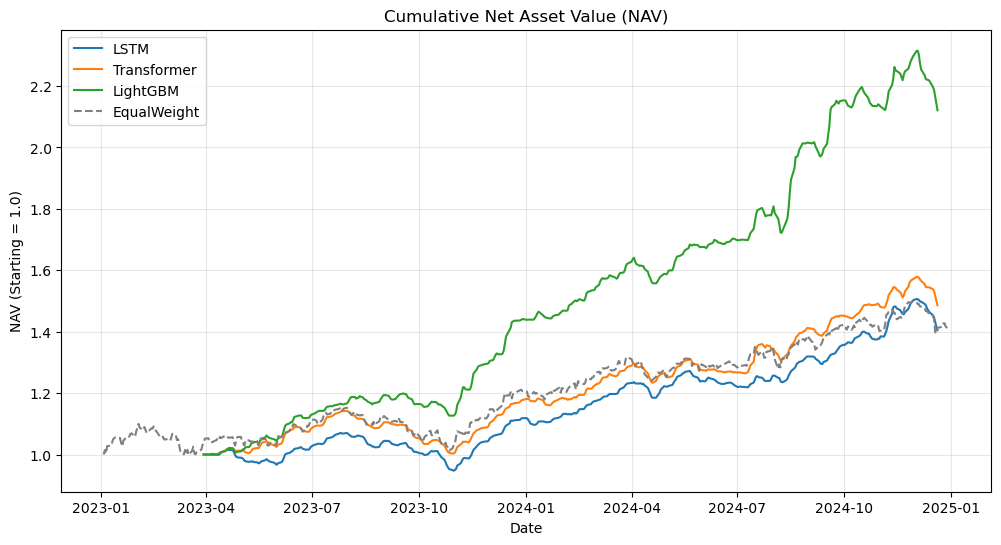

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(nav_lstm.index, nav_lstm.values, label="LSTM")
plt.plot(nav_transformer.index, nav_transformer.values, label="Transformer")
plt.plot(nav_lgbm.index, nav_lgbm.values, label="LightGBM")
plt.plot(nav_eq.index, nav_eq.values, label="EqualWeight", linestyle="--", color="gray")

plt.title("Cumulative Net Asset Value (NAV)")
plt.xlabel("Date")
plt.ylabel("NAV (Starting = 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

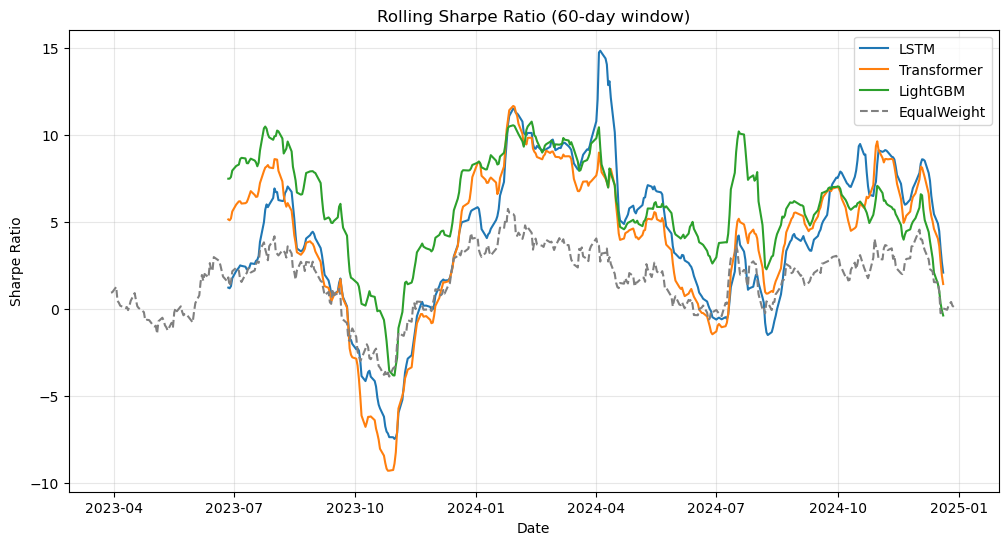

In [36]:
import pandas as pd
import numpy as np

def rolling_sharpe(nav, window=60):  # 60 trading days ≈ 3 months
    returns = nav.pct_change().dropna()
    roll_mean = returns.rolling(window).mean()
    roll_std = returns.rolling(window).std()
    return (roll_mean / roll_std) * np.sqrt(252)  # annualized

plt.figure(figsize=(12,6))
plt.plot(rolling_sharpe(nav_lstm), label="LSTM")
plt.plot(rolling_sharpe(nav_transformer), label="Transformer")
plt.plot(rolling_sharpe(nav_lgbm), label="LightGBM")
plt.plot(rolling_sharpe(nav_eq), label="EqualWeight", linestyle="--", color="gray")

plt.title("Rolling Sharpe Ratio (60-day window)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

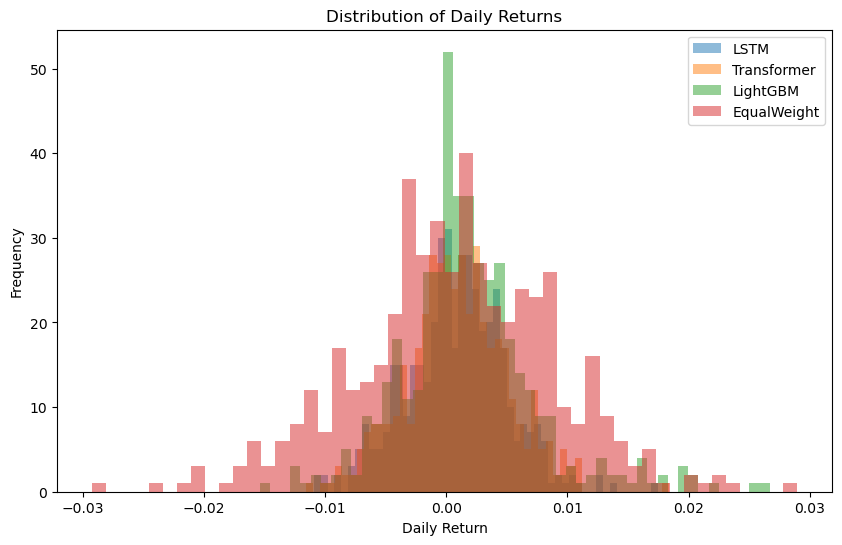

In [38]:
plt.figure(figsize=(10,6))
plt.hist(nav_lstm.pct_change().dropna(), bins=50, alpha=0.5, label="LSTM")
plt.hist(nav_transformer.pct_change().dropna(), bins=50, alpha=0.5, label="Transformer")
plt.hist(nav_lgbm.pct_change().dropna(), bins=50, alpha=0.5, label="LightGBM")
plt.hist(nav_eq.pct_change().dropna(), bins=50, alpha=0.5, label="EqualWeight")

plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

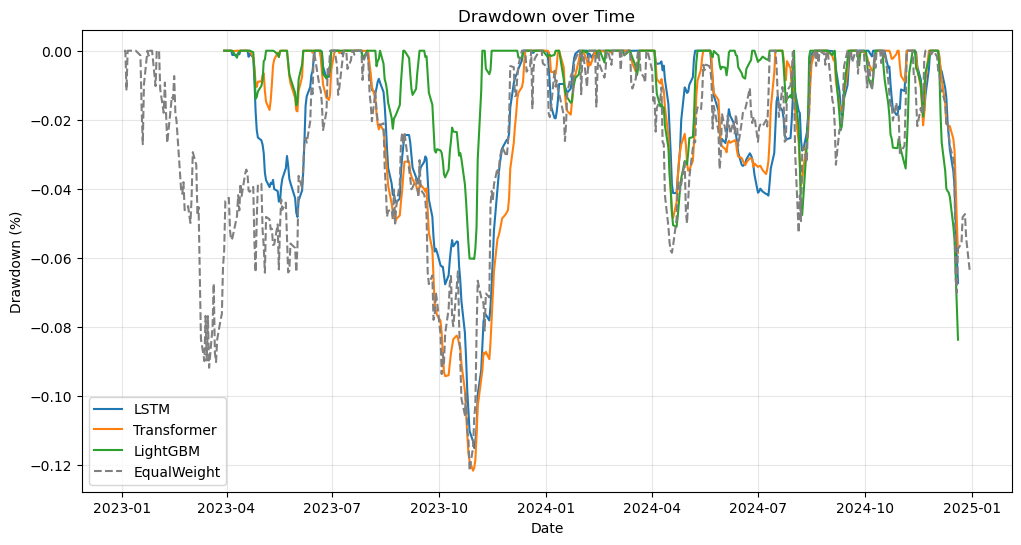

In [39]:
def compute_drawdown(nav):
    cum_max = nav.cummax()
    drawdown = (nav - cum_max) / cum_max
    return drawdown

plt.figure(figsize=(12,6))
plt.plot(compute_drawdown(nav_lstm), label="LSTM")
plt.plot(compute_drawdown(nav_transformer), label="Transformer")
plt.plot(compute_drawdown(nav_lgbm), label="LightGBM")
plt.plot(compute_drawdown(nav_eq), label="EqualWeight", linestyle="--", color="gray")

plt.title("Drawdown over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()